In [29]:
# %% [markdown]
# # Complete Clustering Notebook (step-by-step with progress prints)
# This notebook:
# - Loads datasets
# - Samples UK data (stratified)
# - Builds an adaptive unsupervised feature pipeline
# - Finds k via elbow + silhouette
# - Searches KMeans hyperparameters (randomized)
# - Trains final KMeans, plots distributions, PCA 2D, t-SNE 3D
# - Builds a Decision Tree to explain cluster assignments
# - Computes silhouette on train & test

**Import Neccessary Libraries**

In [1]:
# %% 
# Cell 1 - Imports & constants
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.feature_selection import VarianceThreshold

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

print("sklearn version:", sklearn.__version__)

# random seed
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)



sklearn version: 1.6.1


**Load Datasets**

In [2]:
# %%
# Load datasets
UK_full = pd.read_csv("/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/Datasets/UK-cleaned_data.csv")
US_full = pd.read_csv("/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/Datasets/US_imputed_data.csv")

print(f"US dataset shape: {US_full.shape}")
print(f"UK dataset shape: {UK_full.shape}")

# drop obvious unnecessary columns safely
for df,name in [(UK_full,"UK"), (US_full,"US")]:
    for col in ['latitude','longitude','Report ID','Report Version']:
        if col in df.columns:
            df.drop(columns=[col], inplace=True)
print("Dropped common meta columns (if present).")
print("Shapes after drops:")
print(" UK:", UK_full.shape)
print(" US:", US_full.shape)



US dataset shape: (4032, 21)
UK dataset shape: (229782, 23)
Dropped common meta columns (if present).
Shapes after drops:
 UK: (229782, 19)
 US: (4032, 19)


**Sample UK dataset**

In [3]:
def enhanced_stratified_sample(data, sample_frac=0.2, stratify_col='Highest Injury Severity Alleged'):
    print("\nPerforming stratified sampling...")
    if stratify_col not in data.columns:
        # fallback to first categorical
        possible = data.select_dtypes(include=['object','category']).columns
        if len(possible)==0:
            raise ValueError("No categorical column available for stratification.")
        stratify_col = possible[0]
        print(f"Requested stratify column not found; falling back to {stratify_col}")
    print(f"Stratifying on: {stratify_col}")
    _, sample = train_test_split(
        data,
        test_size=sample_frac,
        stratify=data[stratify_col],
        random_state=RANDOM_STATE
    )
    print("Original distribution (top levels):")
    print(data[stratify_col].value_counts(normalize=True).head(10))
    print("Sample distribution (top levels):")
    print(sample[stratify_col].value_counts(normalize=True).head(10))
    return sample

UK_sampled = enhanced_stratified_sample(UK_full, sample_frac=0.1)
print("UK sampled shape:", UK_sampled.shape)



Performing stratified sampling...
Stratifying on: Highest Injury Severity Alleged
Original distribution (top levels):
Highest Injury Severity Alleged
Minor       0.774512
Serious     0.210086
Fatality    0.015402
Name: proportion, dtype: float64
Sample distribution (top levels):
Highest Injury Severity Alleged
Minor       0.774490
Serious     0.210105
Fatality    0.015405
Name: proportion, dtype: float64
UK sampled shape: (22979, 19)


**Encode the datasets**

In [4]:
UK_sampled.head()
UK_sampled.nunique()



Make                                 50
Model                               483
Model Year                           43
ADS Equipped?                         1
Automation System Engaged?            1
Incident Date                      1825
Incident Time (24:00)              1396
City                               3504
State                                 4
Roadway Type                          5
Roadway Surface                       4
Posted Speed Limit (MPH)              6
Lighting                              5
Crash With                           12
Highest Injury Severity Alleged       3
SV Pre-Crash Movement                17
Weather                               7
SV Contact Area                       5
Country                               2
dtype: int64

In [5]:
US_full.head()
US_full.nunique()

Make                                 54
Model                               150
Model Year                           13
ADS Equipped?                         2
Automation System Engaged?            2
Incident Date                        99
Incident Time (24:00)              1310
City                               1299
State                                51
Roadway Type                          7
Roadway Surface                       4
Posted Speed Limit (MPH)              9
Lighting                              5
Crash With                           15
Highest Injury Severity Alleged       5
SV Pre-Crash Movement                16
Weather                              16
SV Contact Area                      43
Country                               1
dtype: int64

In [6]:
def prepare_for_clustering(df, target_col=None, random_state=42):
    """
    Prepares a dataset for clustering with appropriate encoding of features.
    
    Parameters:
    - df: Input DataFrame
    - target_col: Optional target column for supervised encoding (if needed)
    - random_state: Random seed for reproducibility
    
    Returns:
    - encoded_df: Transformed DataFrame ready for clustering
    - preprocessor: Fitted preprocessing pipeline for future data
    """
    
    # Make a copy to avoid modifying original
    df = df.copy()
    
    # Convert date/time columns if they exist
    if 'Incident Date' in df.columns:
        df['Incident Date'] = pd.to_datetime(df['Incident Date'])
        df['incident_year'] = df['Incident Date'].dt.year
        df['incident_month'] = df['Incident Date'].dt.month
        df['incident_day'] = df['Incident Date'].dt.day
        df['incident_dayofweek'] = df['Incident Date'].dt.dayofweek
        
    if 'Incident Time (24:00)' in df.columns:
        df['Incident Time (24:00)'] = pd.to_datetime(df['Incident Time (24:00)'])
        df['incident_hour'] = df['Incident Time (24:00)'].dt.hour
        df['incident_minute'] = df['Incident Time (24:00)'].dt.minute
        df['time_of_day'] = pd.cut(df['incident_hour'],
                                 bins=[0, 6, 12, 18, 24],
                                 labels=['night', 'morning', 'afternoon', 'evening'],
                                 include_lowest=True)
    
    # Calculate vehicle age if model year exists
    if 'Model Year' in df.columns and 'incident_year' in df.columns:
        df['vehicle_age'] = df['incident_year'] - df['Model Year']
    
    # Define feature categories
    numerical_features = []
    if 'Posted Speed Limit (MPH)' in df.columns:
        numerical_features.append('Posted Speed Limit (MPH)')
    if 'vehicle_age' in df.columns:
        numerical_features.append('vehicle_age')
    
    # Date-derived numerical features
    date_num_features = ['incident_hour', 'incident_minute'] if 'incident_hour' in df.columns else []
    
    # One-hot encode features
    onehot_features = []
    for col in ['State', 'Roadway Type', 'Roadway Surface', 'Lighting', 
               'Highest Injury Severity Alleged', 'Weather', 'SV Contact Area', 
               'Country', 'time_of_day', 'ADS Equipped?','Automation System Engaged?']:
        if col in df.columns:
            onehot_features.append(col)
    
    # Target encode high-cardinality features
    target_encode_features = []
    for col in ['Make', 'Model', 'City', 'Crash With', 'SV Pre-Crash Movement']:
        if col in df.columns:
            target_encode_features.append(col)
    
    # Binary features
    binary_features = []
    for col in []:
        if col in df.columns:
            binary_features.append(col)
    
    # Separate features and target if provided
    X = df.drop(columns=[target_col] if target_col else [])
    y = df[target_col] if target_col else None
    
    # Create preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features + date_num_features),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), onehot_features),
            ('target', TargetEncoder(), target_encode_features) if target_col else ('target', 'passthrough', target_encode_features),
            ('binary', 'passthrough', binary_features)
        ],
        remainder='drop'
    )
    
    # Fit and transform the data
    if target_col:
        encoded_data = preprocessor.fit_transform(X, y)
    else:
        # If no target column, don't use target encoding
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numerical_features + date_num_features),
                ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), onehot_features),
                ('binary', 'passthrough', binary_features)
            ],
            remainder='drop'
        )
        encoded_data = preprocessor.fit_transform(X)
    
    # Get feature names
    feature_names = []
    feature_names.extend(numerical_features + date_num_features)
    
    if 'onehot' in preprocessor.named_transformers_:
        ohe = preprocessor.named_transformers_['onehot']
        for i, col in enumerate(onehot_features):
            cats = ohe.categories_[i]
            feature_names.extend([f"{col}_{cat}" for cat in cats])
    
    if target_col:
        feature_names.extend(target_encode_features)
    
    feature_names.extend(binary_features)
    
    # Create DataFrame with feature names
    encoded_df = pd.DataFrame(encoded_data, columns=feature_names)
    
    return encoded_df, preprocessor



In [7]:
# Example usage without target (for clustering)
us_encoded, preprocessor = prepare_for_clustering(US_full)
us_encoded.head()

# Save the encoded dataset to a CSV file
us_encoded.to_csv("/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/Datasets/US_encoded.csv", index=False)

In [8]:
# Example usage without target (for clustering)
uk_encoded, preprocessor = prepare_for_clustering(UK_sampled)
uk_encoded.head()

# Save the encoded dataset to a CSV file
uk_encoded.to_csv("/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/Datasets/UK_encoded.csv", index=False)

**Running. Kmeans**

In [38]:
from sklearn.model_selection import ParameterSampler
from scipy.stats import randint, uniform

def random_kmeans_search(X, n_iter=10, random_state=42):
    # Define parameter space
    param_dist = {
        'n_clusters': randint(2, 10),
        'init': ['k-means++', 'random'],
        'n_init': randint(5, 30),
        'max_iter': randint(100, 500),
        'tol': uniform(1e-5, 1e-2)
    }
    
    # Sample parameter sets
    param_list = list(ParameterSampler(param_dist, n_iter=n_iter, random_state=random_state))
    results = []

    for params in param_list:
        kmeans = KMeans(random_state=random_state, **params)
        labels = kmeans.fit_predict(X)
        sil = silhouette_score(X, labels)
        results.append((params, sil))

    # Sort by silhouette score
    results.sort(key=lambda x: x[1], reverse=True)
    print("\nTop 3 hyperparameter sets:")
    for p, s in results[:3]:
        print(f"Silhouette={s:.3f} | Params={p}")
    
    return results[0]  # return best


In [55]:
from sklearn.model_selection import ParameterSampler
from scipy.stats import randint, uniform
import numpy as np

def random_kmeans_search(X, n_iter=15, show_progress=False):
    param_grid = {
        "n_init": [10, 15, 20],
        "max_iter": [300, 400, 500],
        "init": ["k-means++", "random"]
    }
    
    best_score = -1
    best_params = None
    
    iterator = tqdm(range(n_iter), desc="Random Search", unit="iter") if show_progress else range(n_iter)
    
    for _ in iterator:
        params = {
            "n_init": np.random.choice(param_grid["n_init"]),
            "max_iter": np.random.choice(param_grid["max_iter"]),
            "init": np.random.choice(param_grid["init"])
        }
        
        kmeans = KMeans(n_clusters=3, random_state=42, **params)  # default k for search
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        
        if score > best_score:
            best_score = score
            best_params = params
    
    
    print(best_params)
    return best_params, best_score



In [56]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

def elbow_and_silhouette(X, k_min=2, k_max=10):
    distortions = []
    sil_scores = []
    
    for k in range(k_min, k_max + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
        kmeans.fit(X)
        distortions.append(kmeans.inertia_)  # Elbow method metric
        sil_scores.append(silhouette_score(X, kmeans.labels_))  # Silhouette score
    
    # Plotting both on the same chart
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    
    ax1.plot(range(k_min, k_max+1), distortions, 'bo-', label='Distortion')
    ax2.plot(range(k_min, k_max+1), sil_scores, 'ro-', label='Silhouette')
    
    ax1.set_xlabel('Number of clusters (k)')
    ax1.set_ylabel('Distortion (Elbow)', color='b')
    ax2.set_ylabel('Silhouette Score', color='r')
    plt.title("Elbow & Silhouette Analysis")
    plt.show()
    
    optimal_k = sil_scores.index(max(sil_scores)) + k_min
    print(f"Best k by silhouette: {optimal_k}")
    return optimal_k



=== US Dataset ===


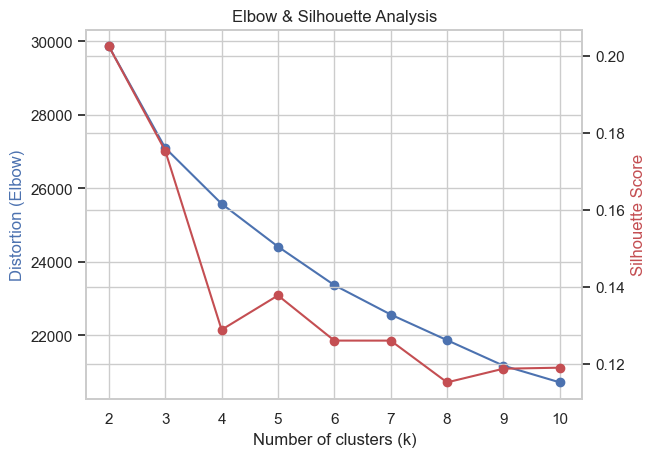

Best k by silhouette: 2


Random Search: 100%|██████████| 15/15 [00:18<00:00,  1.24s/iter]


{'n_init': 20, 'max_iter': 400, 'init': 'random'}
Final silhouette score for US Dataset: 0.203


In [57]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm

def run_kmeans_workflow(X, dataset_name):
    print(f"\n=== {dataset_name} ===")
    
    # Step 1: Elbow + silhouette
    optimal_k = elbow_and_silhouette(X)
    
    # Step 2: Random hyperparameter search with tqdm
    best_params, best_score = random_kmeans_search(X, n_iter=15, show_progress=True)
    
    # Step 3: Train KMeans with best parameters but fixed k
    best_params['n_clusters'] = optimal_k
    kmeans = KMeans(random_state=42, **best_params)
    labels = kmeans.fit_predict(X)
    
    # Step 4: Final evaluation
    sil = silhouette_score(X, labels)
    print(f"Final silhouette score for {dataset_name}: {sil:.3f}")
    
    return kmeans, labels

# Assuming your datasets are already encoded in variables UK_encoded and US_encoded
us_model, us_labels = run_kmeans_workflow(us_encoded, "US Dataset")



=== UK Dataset ===


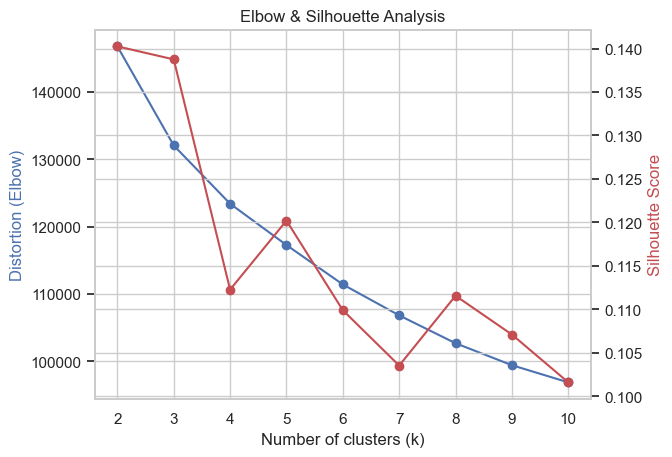

Best k by silhouette: 2


Random Search: 100%|██████████| 15/15 [02:05<00:00,  8.39s/iter]


{'n_init': 15, 'max_iter': 500, 'init': 'k-means++'}
Final silhouette score for UK Dataset: 0.140


In [58]:
uk_model, uk_labels = run_kmeans_workflow(uk_encoded, "UK Dataset")

**Running K-means + Decision Tree**

In [59]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def run_kmeans_with_explainability(X, dataset_name, params, run_decision_tree=True, plot_tree_flag=True):
    """
    Runs KMeans with given parameters, evaluates performance, and optionally trains a decision tree for explainability.
    
    X : DataFrame or ndarray
        Input features (encoded dataset).
    dataset_name : str
        Name of dataset for reporting.
    params : dict
        Dictionary of KMeans parameters (e.g., {'n_clusters': 4, 'init': 'k-means++', 'max_iter': 300, 'n_init': 20}).
    run_decision_tree : bool
        Whether to train a decision tree to explain cluster assignments.
    plot_tree_flag : bool
        Whether to plot the decision tree.
    """
    
    print(f"\n=== Running KMeans for {dataset_name} ===")
    print(f"Parameters: {params}")
    
    # Step 1: Fit KMeans
    kmeans = KMeans(random_state=42, **params)
    labels = kmeans.fit_predict(X)
    
    # Step 2: Evaluation
    sil = silhouette_score(X, labels)
    unique, counts = np.unique(labels, return_counts=True)
    cluster_counts = dict(zip(unique, counts))
    
    print(f"Silhouette Score: {sil:.3f}")
    print(f"Cluster Counts: {cluster_counts}")
    
    # Step 3: Decision Tree for Explainability
    if run_decision_tree:
        print("\nTraining Decision Tree for Explainability...")
        dt = DecisionTreeClassifier(random_state=42, max_depth=4)
        dt.fit(X, labels)
        feature_importances = pd.Series(dt.feature_importances_, index=getattr(X, "columns", range(X.shape[1])))
        print("\nFeature Importances:")
        print(feature_importances.sort_values(ascending=False))
        
        if plot_tree_flag:
            plt.figure(figsize=(15, 8))
            plot_tree(dt, feature_names=getattr(X, "columns", None), class_names=[str(c) for c in np.unique(labels)], filled=True)
            plt.title(f"Decision Tree - {dataset_name}")
            plt.show()
    
    return {
        "model": kmeans,
        "labels": labels,
        "silhouette": sil,
        "cluster_counts": cluster_counts
    }



=== Running KMeans for UK Dataset ===
Parameters: {'n_clusters': 3, 'init': 'k-means++', 'max_iter': 500, 'n_init': 15}
Silhouette Score: 0.175
Cluster Counts: {0: 1029, 1: 1686, 2: 1317}

Training Decision Tree for Explainability...

Feature Importances:
Automation System Engaged?_ADS           0.527542
incident_hour                            0.413494
Roadway Type_Highway / Freeway           0.028095
Lighting_Daylight                        0.016707
time_of_day_morning                      0.010278
                                           ...   
State_TX                                 0.000000
State_TN                                 0.000000
State_SD                                 0.000000
State_SC                                 0.000000
Highest Injury Severity Alleged_Minor    0.000000
Length: 144, dtype: float64


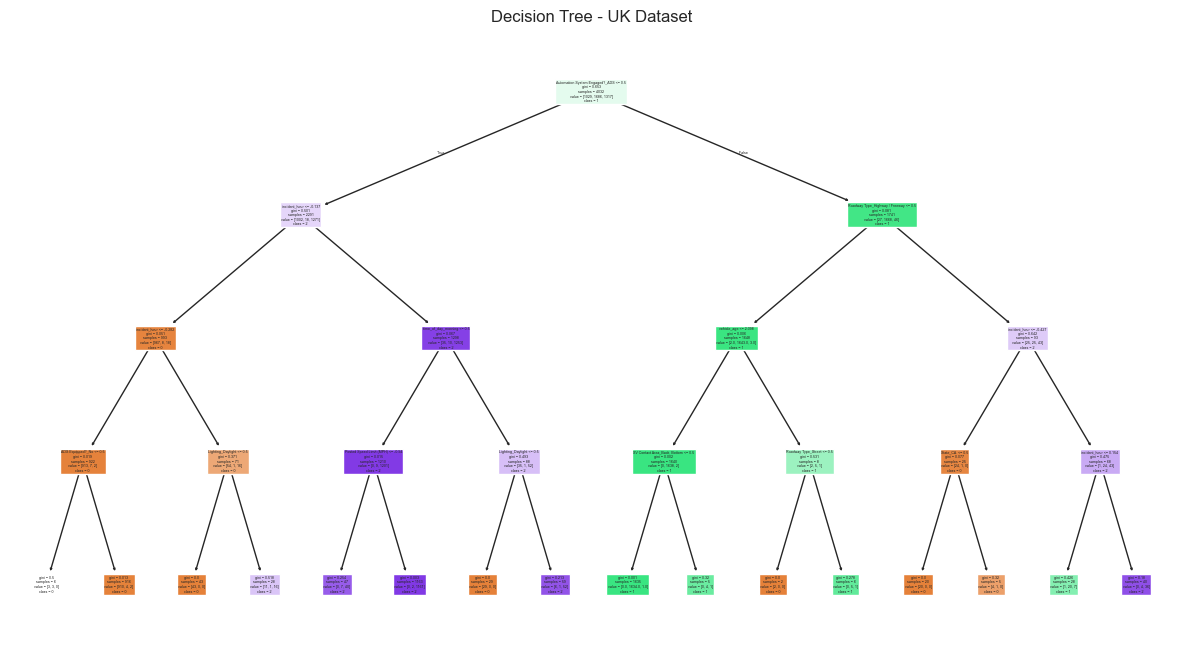

In [63]:
# Example parameters
uk_params = {
    "n_clusters": 3,
    "init": "k-means++",
    "max_iter": 500,
    "n_init": 15
}

# Run for UK dataset
uk_results = run_kmeans_with_explainability(us_encoded, "UK Dataset", uk_params)



=== Running KMeans for US Dataset ===
Parameters: {'n_clusters': 3, 'init': 'random', 'max_iter': 400, 'n_init': 20}
Silhouette Score: 0.175
Cluster Counts: {0: 1687, 1: 1029, 2: 1316}

Training Decision Tree for Explainability...

Feature Importances:
Automation System Engaged?_ADS           0.528364
incident_hour                            0.413277
Roadway Type_Highway / Freeway           0.028153
Lighting_Daylight                        0.016169
time_of_day_morning                      0.010281
                                           ...   
State_TX                                 0.000000
State_TN                                 0.000000
State_SD                                 0.000000
State_SC                                 0.000000
Highest Injury Severity Alleged_Minor    0.000000
Length: 144, dtype: float64


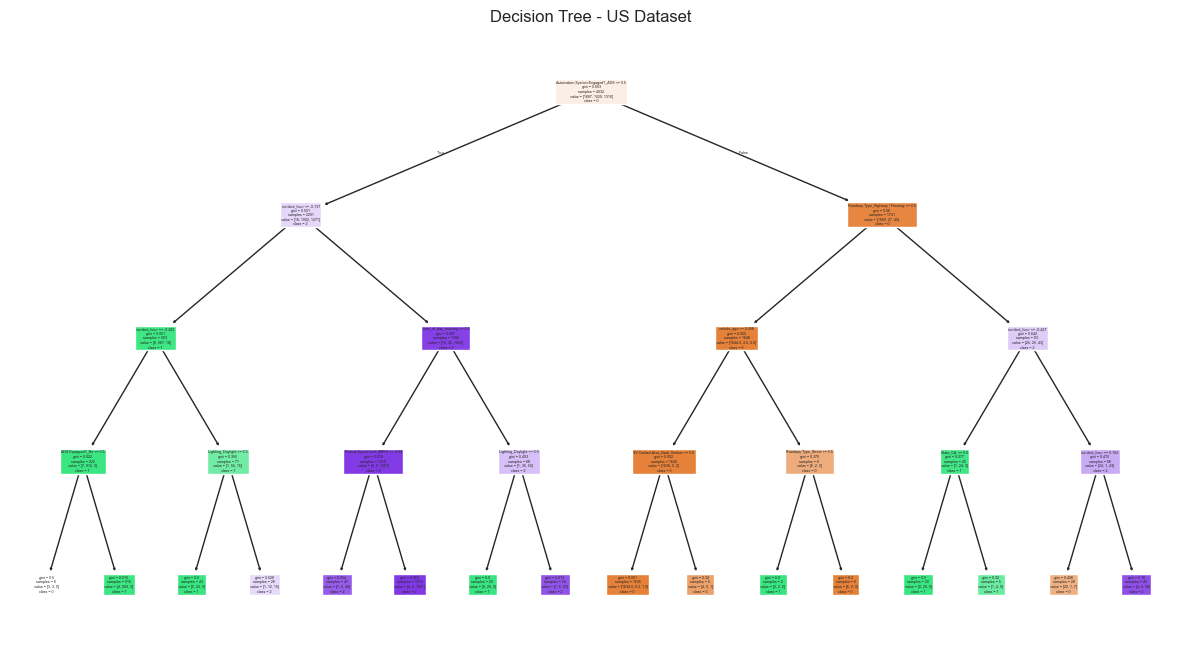

In [61]:
us_params = {
    "n_clusters": 3,
    "init": "random",
    "max_iter": 400,
    "n_init": 20
}



# Run for US dataset
us_results = run_kmeans_with_explainability(us_encoded, "US Dataset", us_params)


**PCA 2D plot**

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def run_kmeans_with_explainability_and_plots(X, dataset_name, params, run_decision_tree=True, plot_tree_flag=True):
    print(f"\n=== Running KMeans for {dataset_name} ===")
    print(f"Parameters: {params}")
    
    # Step 1: Fit KMeans
    kmeans = KMeans(random_state=42, **params)
    labels = kmeans.fit_predict(X)
    
    # Step 2: Evaluation
    sil = silhouette_score(X, labels)
    unique, counts = np.unique(labels, return_counts=True)
    cluster_counts = dict(zip(unique, counts))
    
    print(f"Silhouette Score: {sil:.3f}")
    print(f"Cluster Counts: {cluster_counts}")
    
    # Step 3: PCA 2D Plot
    print("Plotting PCA 2D...")
    pca_2d = PCA(n_components=2, random_state=42).fit_transform(X)
    plt.figure(figsize=(6, 5))
    sns.scatterplot(x=pca_2d[:, 0], y=pca_2d[:, 1], hue=labels, palette="viridis", s=50)
    plt.title(f"PCA 2D - {dataset_name}")
    plt.show()
    
    # Step 4: t-SNE 2D Plot
    print("Plotting t-SNE 2D (may take a while)...")
    tsne_2d = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000).fit_transform(X)
    plt.figure(figsize=(6, 5))
    sns.scatterplot(x=tsne_2d[:, 0], y=tsne_2d[:, 1], hue=labels, palette="magma", s=50)
    plt.title(f"t-SNE 2D - {dataset_name}")
    plt.show()
    
    # Step 5: t-SNE 3D Plot
    print("Plotting t-SNE 3D (may take a while)...")
    tsne_3d = TSNE(n_components=3, random_state=42, perplexity=30, n_iter=1000).fit_transform(X)
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(tsne_3d[:, 0], tsne_3d[:, 1], tsne_3d[:, 2], c=labels, cmap='magma', s=50)
    ax.set_title(f"t-SNE 3D - {dataset_name}")
    fig.colorbar(scatter)
    plt.show()
    
    # Step 6: Decision Tree for Explainability
    if run_decision_tree:
        print("\nTraining Decision Tree for Explainability...")
        dt = DecisionTreeClassifier(random_state=42, max_depth=4)
        dt.fit(X, labels)
        feature_importances = pd.Series(dt.feature_importances_, index=getattr(X, "columns", range(X.shape[1])))
        print("\nFeature Importances:")
        print(feature_importances.sort_values(ascending=False))
        
        if plot_tree_flag:
            plt.figure(figsize=(15, 8))
            plot_tree(dt, feature_names=getattr(X, "columns", None), class_names=[str(c) for c in np.unique(labels)], filled=True)
            plt.title(f"Decision Tree - {dataset_name}")
            plt.show()
    
    return {
        "model": kmeans,
        "labels": labels,
        "silhouette": sil,
        "cluster_counts": cluster_counts
    }




=== Running KMeans for US Dataset ===
Parameters: {'n_clusters': 3, 'init': 'random', 'max_iter': 400, 'n_init': 20}
Silhouette Score: 0.175
Cluster Counts: {0: 1687, 1: 1029, 2: 1316}
Plotting PCA 2D...


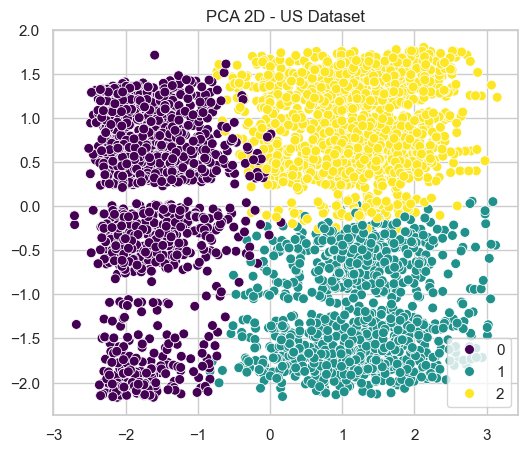

Plotting t-SNE 2D (may take a while)...


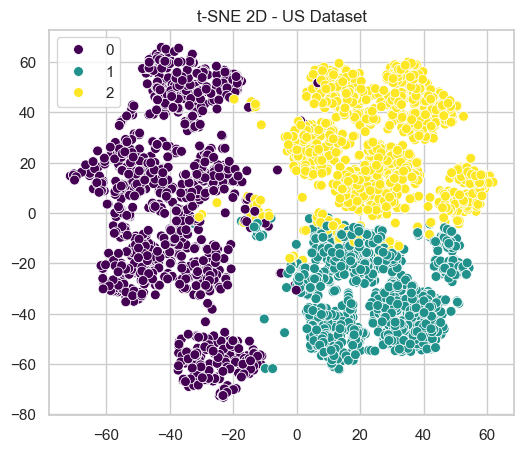

Plotting t-SNE 3D (may take a while)...


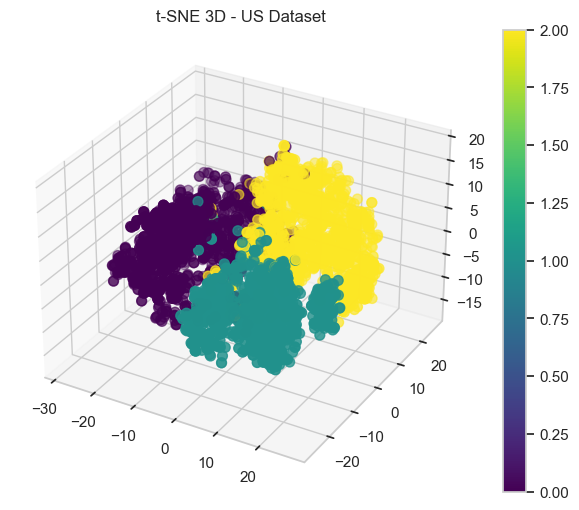


Training Decision Tree for Explainability...

Feature Importances:
Automation System Engaged?_ADS           0.528364
incident_hour                            0.413277
Roadway Type_Highway / Freeway           0.028153
Lighting_Daylight                        0.016169
time_of_day_morning                      0.010281
                                           ...   
State_TX                                 0.000000
State_TN                                 0.000000
State_SD                                 0.000000
State_SC                                 0.000000
Highest Injury Severity Alleged_Minor    0.000000
Length: 144, dtype: float64


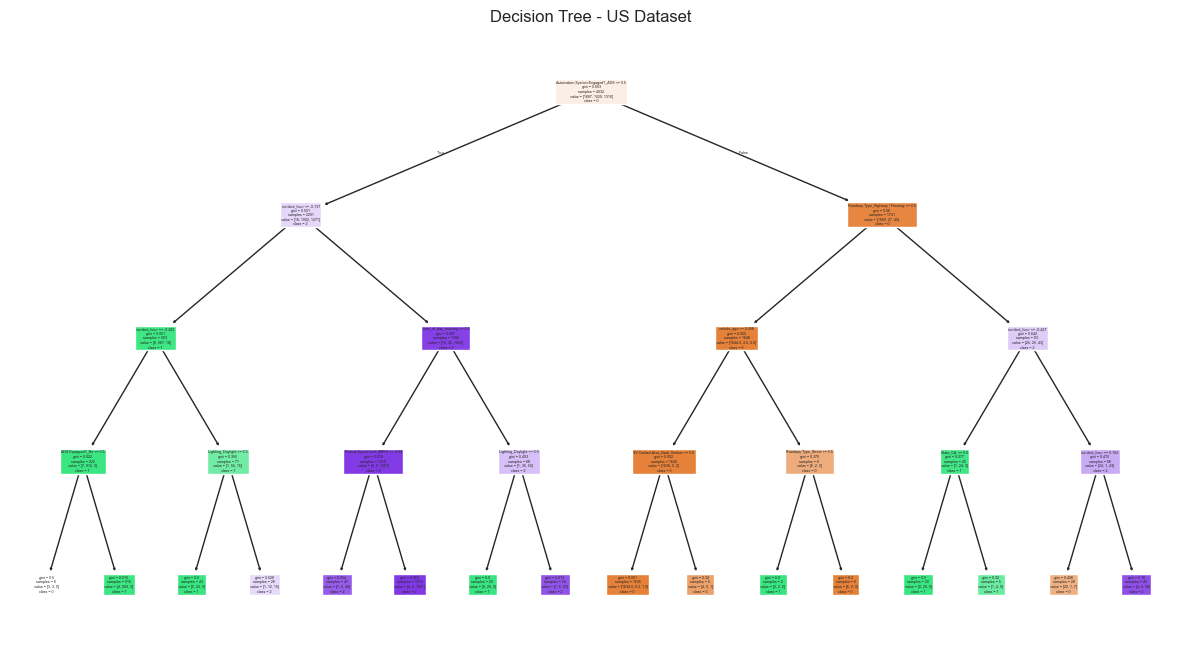

In [67]:
us_results = run_kmeans_with_explainability_and_plots(us_encoded, "US Dataset", us_params)



=== Running KMeans for UK Dataset ===
Parameters: {'n_clusters': 3, 'init': 'k-means++', 'max_iter': 500, 'n_init': 15}
Silhouette Score: 0.139
Cluster Counts: {0: 6524, 1: 11126, 2: 5329}
Plotting PCA 2D...


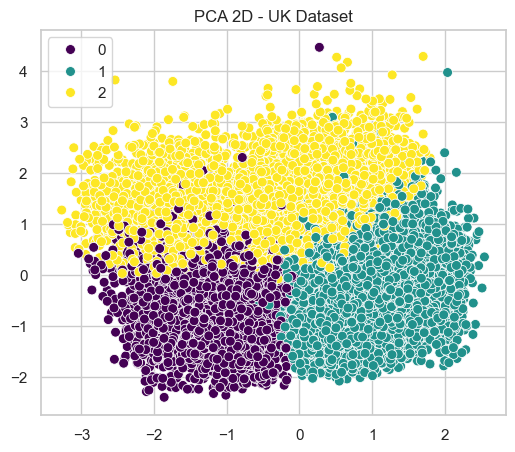

Plotting t-SNE 2D (may take a while)...


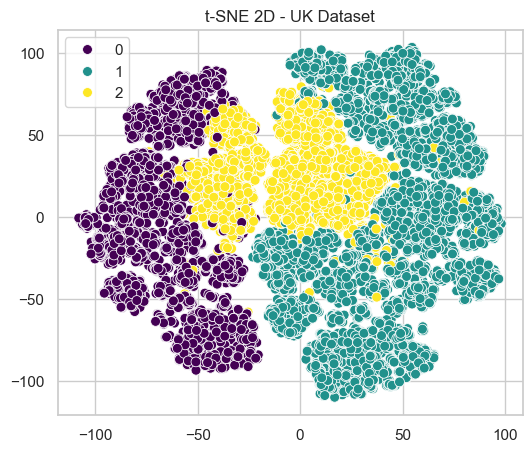

Plotting t-SNE 3D (may take a while)...


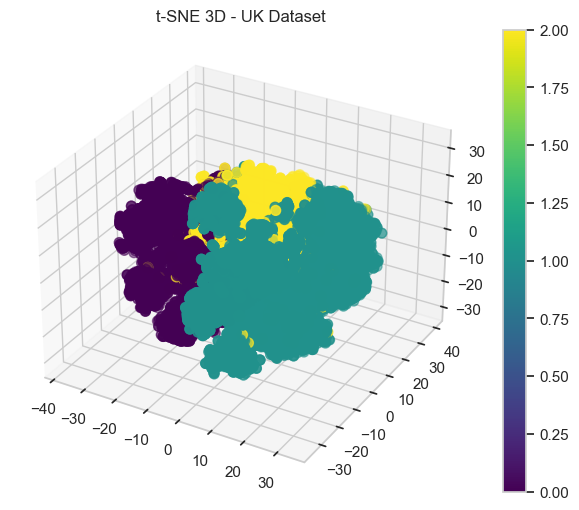


Training Decision Tree for Explainability...

Feature Importances:
Posted Speed Limit (MPH)                    0.543701
incident_hour                               0.456019
vehicle_age                                 0.000280
ADS Equipped?_Conventional                  0.000000
time_of_day_night                           0.000000
Weather_Clear                               0.000000
Weather_Fog or mist                         0.000000
Weather_Other                               0.000000
Weather_Raining + high winds                0.000000
Weather_Raining no high winds               0.000000
Weather_Snowing + high winds                0.000000
Weather_Snowing no high winds               0.000000
SV Contact Area_Back                        0.000000
SV Contact Area_Did not impact              0.000000
SV Contact Area_Front                       0.000000
Highest Injury Severity Alleged_Serious     0.000000
SV Contact Area_Offside                     0.000000
Country_Ghana                  

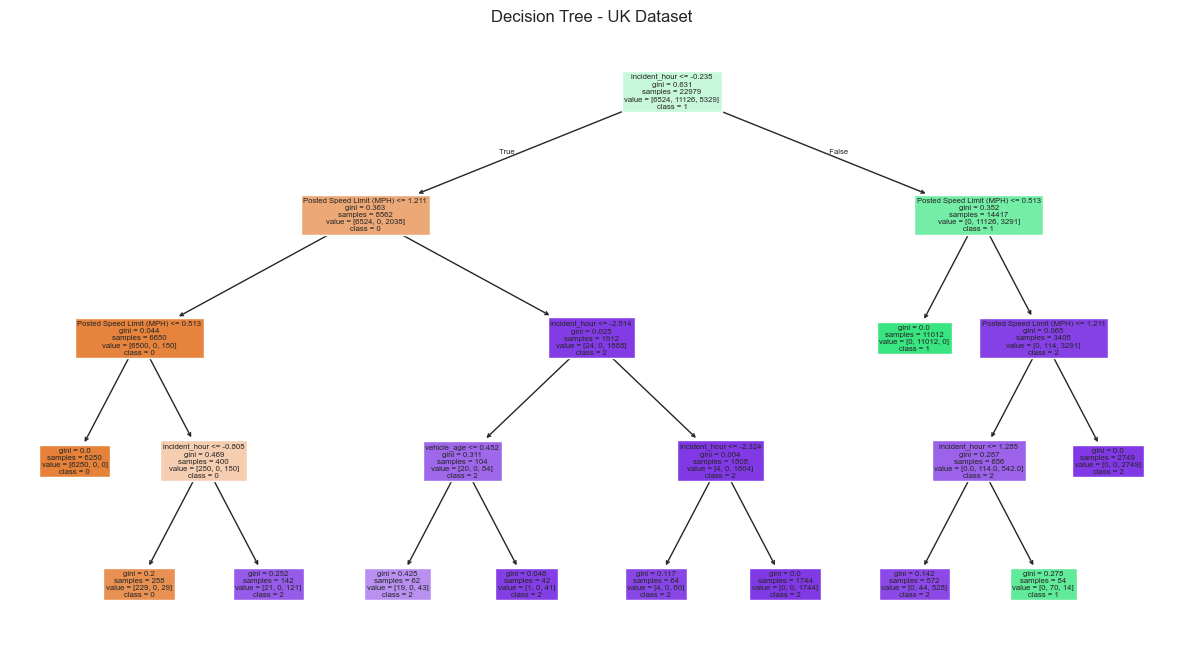

In [68]:

uk_results = run_kmeans_with_explainability_and_plots(uk_encoded, "UK Dataset", uk_params)


**Cluster Labelling**

In [74]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def cluster_profiling(X, labels, max_cat_levels=8, top_n=10, plot=True, palette_name="pastel"):
    """
    Creates a cluster profiling summary table + optional plots for the top N most distinguishing features.
    
    X: DataFrame (original, not one-hot encoded if possible)
    labels: Cluster labels from KMeans
    max_cat_levels: Max unique values in a column to be considered categorical
    top_n: Number of features to plot based on their variation between clusters
    plot: Whether to plot distributions
    palette_name: seaborn color palette name ('pastel', 'Set2', 'husl', etc.)
    """
    df = X.copy()
    df["Cluster"] = labels
    
    profile = {}
    variation_scores = {}
    
    # Pick a nice consistent palette for clusters
    unique_clusters = sorted(df["Cluster"].unique())
    cluster_palette = sns.color_palette(palette_name, n_colors=len(unique_clusters))
    
    for col in df.columns:
        if col == "Cluster":
            continue
        
        if df[col].dtype in ["object", "category"] or df[col].nunique() <= max_cat_levels:
            mode_per_cluster = df.groupby("Cluster")[col].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
            profile[col] = mode_per_cluster
            
            freq_table = pd.crosstab(df["Cluster"], df[col], normalize="index")
            variation_scores[col] = freq_table.var(axis=1).mean()
        else:
            mean_per_cluster = df.groupby("Cluster")[col].mean()
            profile[col] = mean_per_cluster
            
            variation_scores[col] = mean_per_cluster.var()
    
    profile_df = pd.DataFrame(profile)
    print("\n=== Cluster Profiling Table ===")
    display(profile_df)
    
    top_features = sorted(variation_scores, key=variation_scores.get, reverse=True)[:top_n]
    
    if plot:
        sns.set_style("whitegrid")
        for col in top_features:
            plt.figure(figsize=(6, 4))
            if df[col].dtype in ["object", "category"] or df[col].nunique() <= max_cat_levels:
                sns.countplot(data=df, x=col, hue="Cluster", palette=cluster_palette)
                plt.xticks(rotation=45)
            else:
                sns.boxplot(data=df, x="Cluster", y=col, palette=cluster_palette)
            plt.title(f"{col} distribution by cluster", fontsize=12, fontweight="bold")
            plt.xlabel(col, fontsize=10)
            plt.ylabel("Count" if df[col].dtype in ["object", "category"] else "Value", fontsize=10)
            plt.tight_layout()
            plt.show()
    
    return profile_df




=== Cluster Profiling Table ===


,Make,Model,Model Year,ADS Equipped?,Automation System Engaged?,Incident Date,Incident Time (24:00),City,State,Roadway Type,Roadway Surface,Posted Speed Limit (MPH),Lighting,Crash With,Highest Injury Severity Alleged,SV Pre-Crash Movement,Weather,SV Contact Area,Country
Cluster,,,,,,,,,,,,,,,,,,,
0,Jaguar,I-Pace,2022.009484,Yes,ADS,2025-04-08,23:30:00,San Francisco,CA,Street,Dry,25.435685,Daylight,Passenger Car,No Injuries Reported,Stopped,Clear,Back,US
1,Tesla,Model 3,2021.170068,No,ADAS,2025-10-24,02:28:00,Los Angeles,CA,Highway / Freeway,Dry,54.499514,Dark - Lighted,Other Fixed Object,No Injuries Reported,Proceeding Straight,Clear,Front,US
2,Tesla,Model Y,2021.264438,No,ADAS,2025-04-25,18:00:00,Los Angeles,CA,Highway / Freeway,Dry,54.665653,Daylight,Other Fixed Object,No Injuries Reported,Proceeding Straight,Clear,Front,US


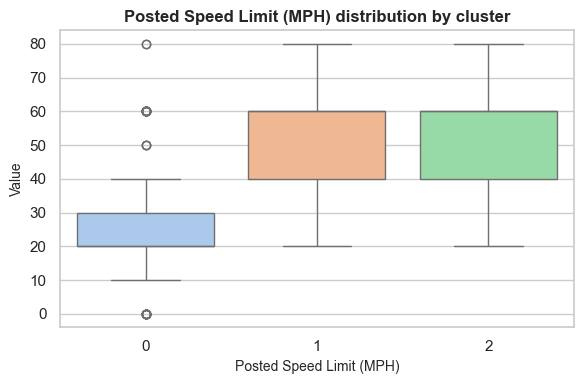

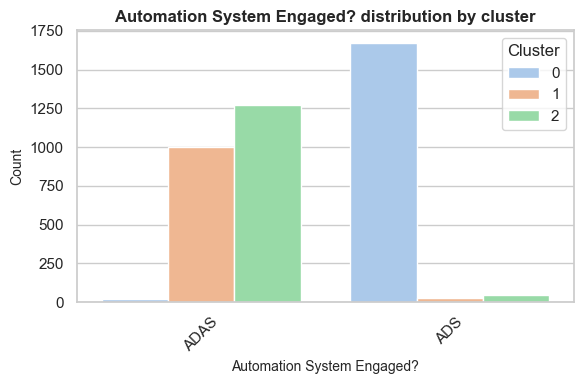

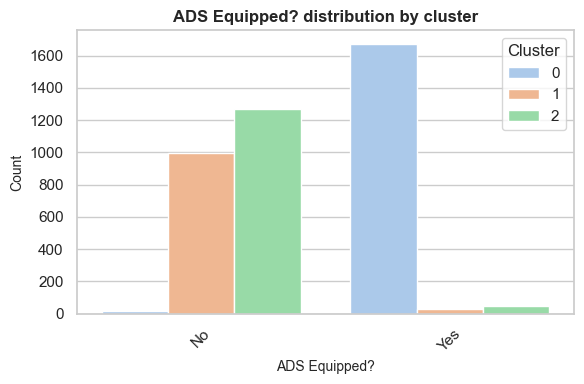

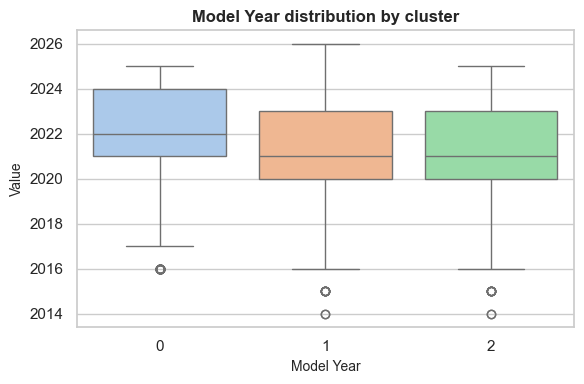

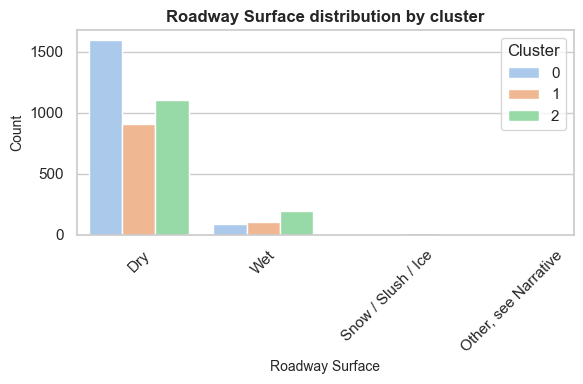

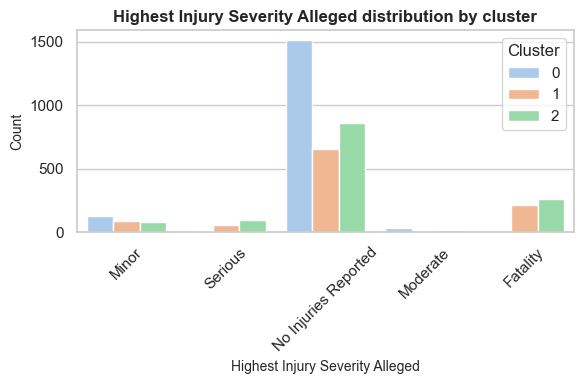

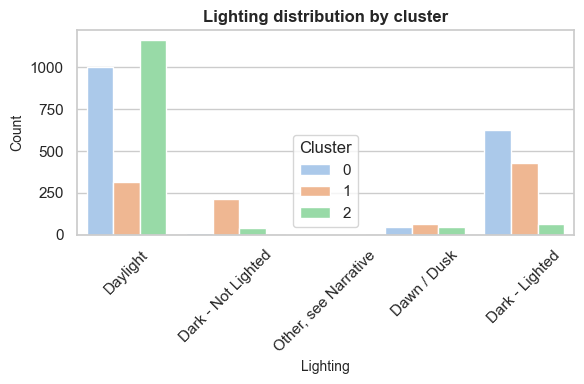

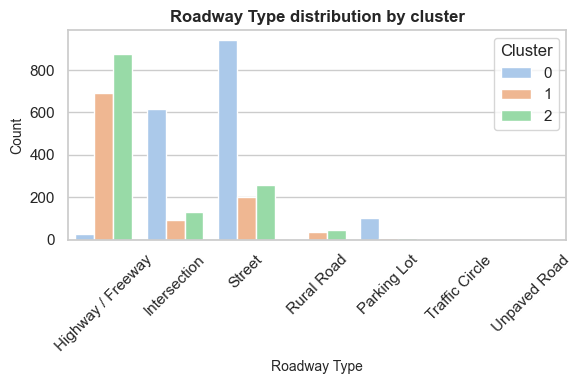

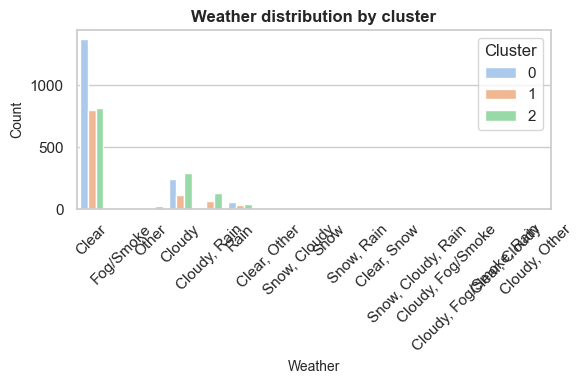

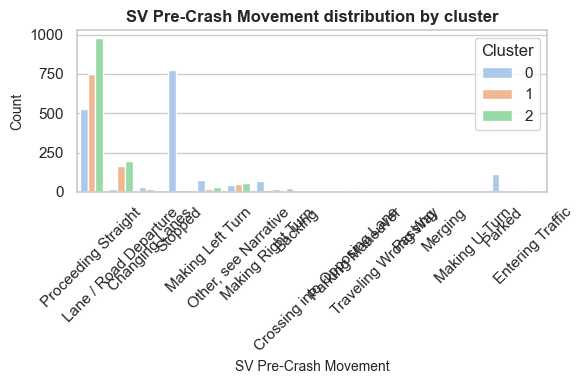

In [75]:
cluster_summary = cluster_profiling(US_full, us_results["labels"])



=== Cluster Profiling Table ===


,Make,Model,Model Year,ADS Equipped?,Automation System Engaged?,Incident Date,Incident Time (24:00),City,State,Roadway Type,Roadway Surface,Posted Speed Limit (MPH),Lighting,Crash With,Highest Injury Severity Alleged,SV Pre-Crash Movement,Weather,SV Contact Area,Country
Cluster,,,,,,,,,,,,,,,,,,,
0,VAUXHALL,FIESTA,2012.183323,Conventional,Conventional,2020-03-06,08:30:00,Birmingham,England,Single carriageway,Dry,30.0,Daylight,No Object,Minor,Going ahead other,Clear,Front,United Kingdom
1,FORD,FIESTA,2011.812601,Conventional,Conventional,2020-09-17,17:00:00,Bradford,England,Single carriageway,Dry,30.0,Daylight,No Object,Minor,Going ahead other,Clear,Front,United Kingdom
2,FORD,FIESTA,2011.425408,Conventional,Conventional,2019-12-13,17:00:00,Ashford,England,Single carriageway,Dry,60.0,Daylight,No Object,Minor,Going ahead other,Clear,Front,United Kingdom


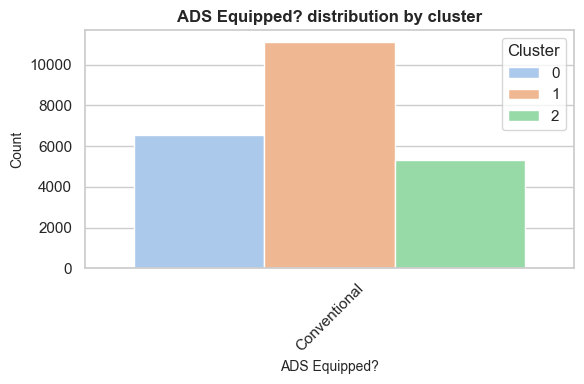

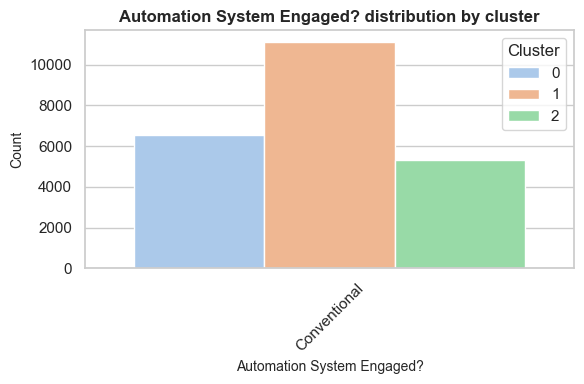

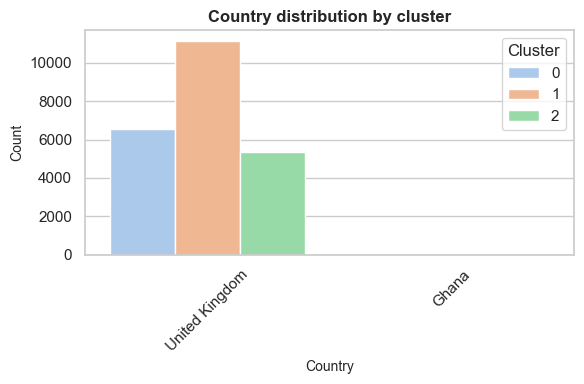

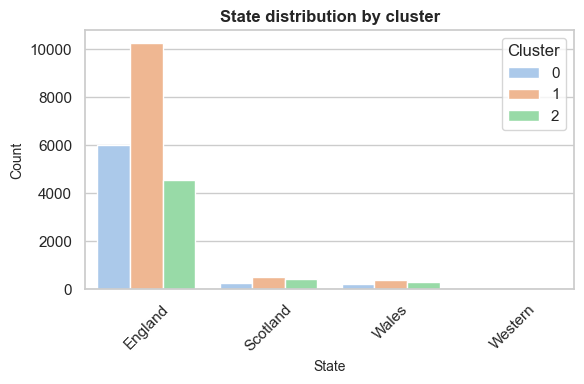

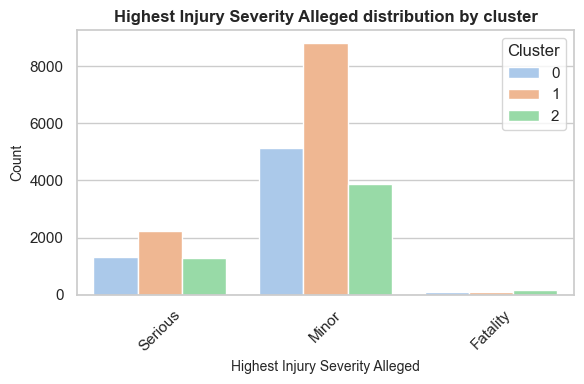

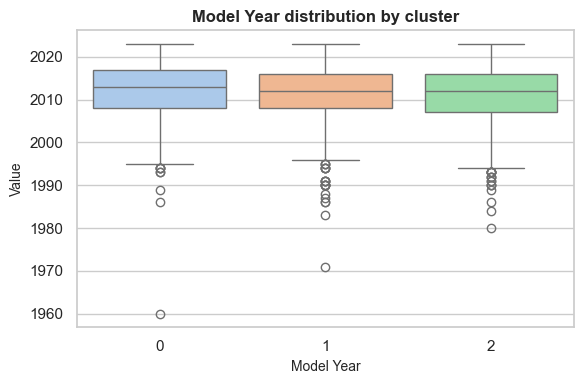

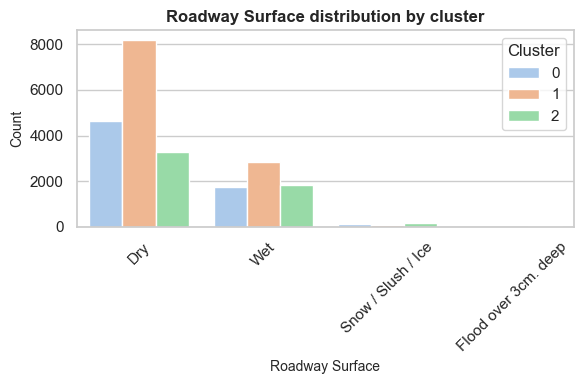

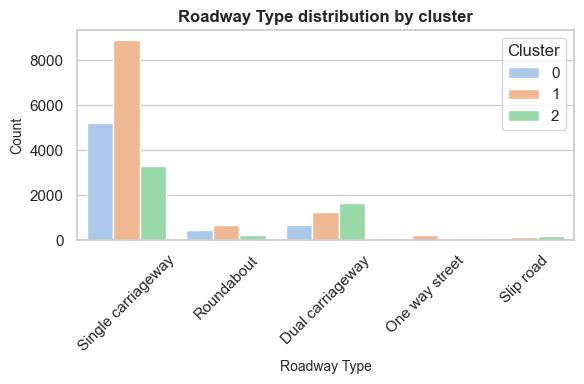

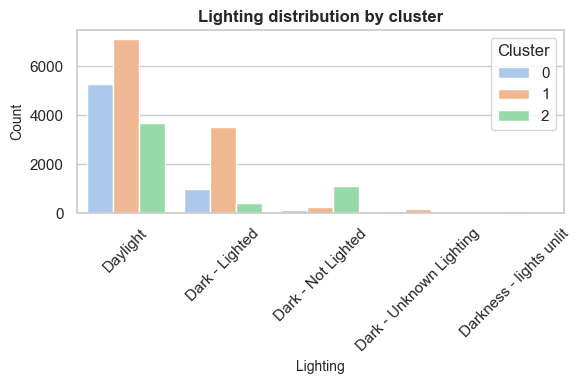

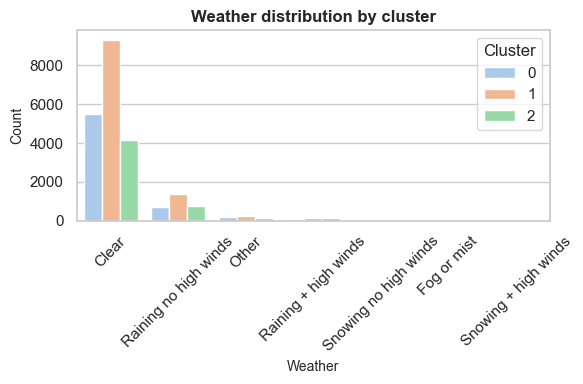

In [ ]:
cluster_summary = cluster_profiling(UK_sampled, uk_results["labels"])